In [1]:
import timm
import json
import torch
import numpy as np
import pandas as pd
from torch import nn
from tqdm import tqdm
from PIL import Image
from pathlib import Path
import torch.optim as optim
from torchvision import transforms
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
GLOBAL_SEED=123
np.random.seed(GLOBAL_SEED)

In [3]:
kaggle_root = Path('/kaggle/input')
dataset_root = kaggle_root / 'imaterialist-fashion-2020-fgvc7'
models_root = kaggle_root / 'saved-models-imaterialist-embedding-extraction'
train_df_path = dataset_root / 'train.csv'
# images_folder = dataset_root / 'train'
images_folder = kaggle_root / 'imaterialist-train-224x224' / 'train_224'
desc_path = dataset_root / 'label_descriptions.json'

In [4]:
full_dataset_df = pd.read_csv(train_df_path)

In [5]:
full_dataset_groupped = full_dataset_df[
    ['ImageId', 'ClassId']
].groupby('ImageId')[
    'ClassId'
].agg([('ClassIds', lambda xs: list(xs))])

In [6]:
N_CLASSES=len(set(full_dataset_df['ClassId']))
print("Number of classes: ", N_CLASSES)

Number of classes:  46


In [7]:
class_descriptions = json.load(open(desc_path))
class_descriptions = list(map(lambda x: x[1], sorted(list(map(
    lambda x: (x['id'], x['name']),
    class_descriptions['categories']
)), key=lambda x: x[0])))
class_descriptions = np.array(class_descriptions)

In [8]:
class FashionDataset(Dataset):
    def __init__(self, dataframe, image_folder, n_classes=N_CLASSES, transform=None):
        self.dataframe = dataframe
        self.image_folder = image_folder
        self.transform = transform
        self.n_classes = n_classes

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_id = self.dataframe.iloc[idx].name
        image = Image.open(self.image_folder / f"{image_id}.jpg")
        
        if image.mode == 'L':
            image = image.convert("RGB")

        label_array = np.zeros(self.n_classes, dtype=float)
        label_array[self.dataframe.iloc[idx]['ClassIds']] = 1

        if self.transform:
            image = self.transform(image)

        return image, label_array

In [9]:
train_df, test_df = train_test_split(
    full_dataset_groupped,
    test_size=0.2,
    random_state=GLOBAL_SEED,
)

In [10]:
input_size = 224

train_transform = transforms.Compose([
#     transforms.RandomResizedCrop(input_size, scale=(0.33, 1)),
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

(1) Label:  shirt, blouse; top, t-shirt, sweatshirt; vest; pants; glasses; watch; shoe; collar; sleeve; pocket; neckline
(2) Label:  jacket; sleeve; pocket; neckline
(3) Label:  dress; glasses; shoe; bag, wallet; sleeve; neckline
(4) Label:  dress; headband, head covering, hair accessory; glove; neckline; bead; flower
(5) Label:  dress; shoe; neckline


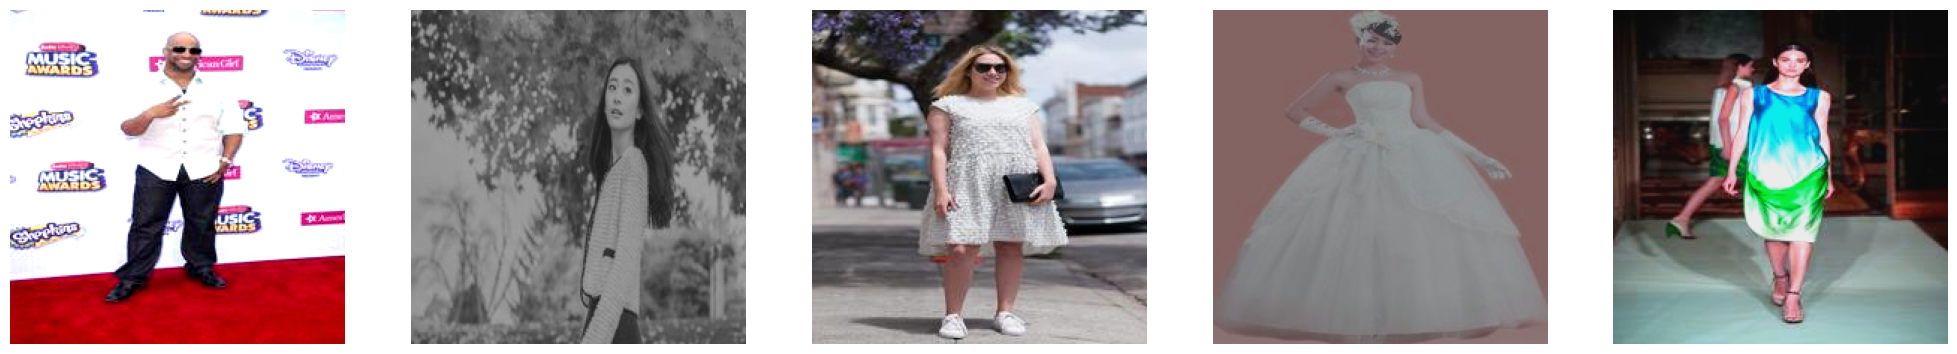

In [11]:
tds = FashionDataset(train_df, images_folder, transform=train_transform)
n = 5
fig, axes = plt.subplots(1, n, figsize=(n*5, 5))
for i, ax in enumerate(axes):
    image, label = tds[i]
    print(f'({i+1}) Label: ', '; '.join(class_descriptions[np.where(label)]))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    for channel in range(3):
        image[channel] *= std[channel]
        image[channel] += mean[channel]
    ax.imshow(image.permute(1, 2, 0))
    ax.axis('off')
plt.show()

In [12]:
train_dataset = FashionDataset(train_df, images_folder, transform=train_transform)
test_dataset = FashionDataset(test_df, images_folder, transform=test_transform)

In [13]:
BATCH_SIZE=32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [14]:
model = timm.create_model('swin_small_patch4_window7_224.ms_in22k_ft_in1k', pretrained=False)

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [15]:
model.head.fc = nn.Linear(model.head.fc.in_features, N_CLASSES)

In [16]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
_ = model.to(device)

In [18]:
SKIP_EPOCHS = 0 # based on model
# small_trainedhead_path = models_root / 'last_layer_trained_small_swin_ep1_best5237.pth'
# model.load_state_dict(torch.load(small_trainedhead_path, map_location=device))

In [19]:
n_params, n_trained = 0, 0
for name, params in model.named_parameters():
    if False:
        pass
#     if 'layers' in name and int(name.split('.')[1]) < 3:
#         params.requires_grad = False
# #         print(f"Removing {name}")
#     elif 'patch_embed' in name:
#         params.requires_grad = False
# #         print(f"Removing {name}")
    else:
        params.requires_grad = True
        n_trained += params.numel()
        print(f"Keeping {name}")
    n_params += params.numel()
    
print(f"Training {n_trained}/{n_params} ({n_trained/n_params*100:.2f}%)")

Keeping patch_embed.proj.weight
Keeping patch_embed.proj.bias
Keeping patch_embed.norm.weight
Keeping patch_embed.norm.bias
Keeping layers.0.blocks.0.norm1.weight
Keeping layers.0.blocks.0.norm1.bias
Keeping layers.0.blocks.0.attn.relative_position_bias_table
Keeping layers.0.blocks.0.attn.qkv.weight
Keeping layers.0.blocks.0.attn.qkv.bias
Keeping layers.0.blocks.0.attn.proj.weight
Keeping layers.0.blocks.0.attn.proj.bias
Keeping layers.0.blocks.0.norm2.weight
Keeping layers.0.blocks.0.norm2.bias
Keeping layers.0.blocks.0.mlp.fc1.weight
Keeping layers.0.blocks.0.mlp.fc1.bias
Keeping layers.0.blocks.0.mlp.fc2.weight
Keeping layers.0.blocks.0.mlp.fc2.bias
Keeping layers.0.blocks.1.norm1.weight
Keeping layers.0.blocks.1.norm1.bias
Keeping layers.0.blocks.1.attn.relative_position_bias_table
Keeping layers.0.blocks.1.attn.qkv.weight
Keeping layers.0.blocks.1.attn.qkv.bias
Keeping layers.0.blocks.1.attn.proj.weight
Keeping layers.0.blocks.1.attn.proj.bias
Keeping layers.0.blocks.1.norm2.weig

In [20]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for i, (inputs, labels) in enumerate(tqdm(dataloader)):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
#         if i > 25: break

    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [21]:
# Computes mean loss and mean Average Precision (mAP)
def test(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(dataloader)):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            all_labels.append(labels.cpu())
            all_predictions.append(torch.sigmoid(outputs).cpu())
            
#             if i > 25: break

    avg_loss = total_loss / len(dataloader)
    all_labels = torch.cat(all_labels)
    all_predictions = torch.cat(all_predictions)

    mAP = average_precision_score(all_labels.numpy(), all_predictions.numpy(), average="macro")
    return avg_loss, mAP

In [22]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=0.000001)

In [23]:
num_epochs = 30
max_mAP = 0
for epoch in range(num_epochs):
    if epoch < SKIP_EPOCHS:
        print(f"\nSKIPPED: Epoch {epoch+1}/{num_epochs}")
        scheduler.step()
        continue
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_mAP = test(model, test_loader, criterion, device)
    print(f"\nEpoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test mAP: {test_mAP:.2f}")
    postfix = f'ep{epoch+1}'
    if test_mAP > max_mAP:
        print("Detected new best test mAP!")
        max_mAP = test_mAP
        postfix += f'_best{test_mAP*10000:.0f}'
    print("Saving model!")
    torch.save(model.state_dict(), f'/kaggle/working/model_{postfix}.pth')
    scheduler.step()
    print()

100%|██████████| 286/286 [00:42<00:00,  6.76it/s]



Epoch 1/30, Train Loss: 0.2608, Test Loss: 0.2581, Test mAP: 0.12
Detected new best test mAP!
Saving model!



100%|██████████| 286/286 [00:42<00:00,  6.77it/s]



Epoch 2/30, Train Loss: 0.2572, Test Loss: 0.2567, Test mAP: 0.12
Detected new best test mAP!
Saving model!



100%|██████████| 286/286 [00:42<00:00,  6.78it/s]



Epoch 3/30, Train Loss: 0.2565, Test Loss: 0.2561, Test mAP: 0.12
Saving model!



100%|██████████| 286/286 [00:42<00:00,  6.78it/s]



Epoch 4/30, Train Loss: 0.2561, Test Loss: 0.2557, Test mAP: 0.12
Saving model!



100%|██████████| 286/286 [00:42<00:00,  6.78it/s]



Epoch 5/30, Train Loss: 0.2559, Test Loss: 0.2561, Test mAP: 0.12
Saving model!



100%|██████████| 286/286 [00:42<00:00,  6.78it/s]



Epoch 6/30, Train Loss: 0.2560, Test Loss: 0.2559, Test mAP: 0.12
Saving model!



100%|██████████| 286/286 [00:42<00:00,  6.78it/s]



Epoch 7/30, Train Loss: 0.2559, Test Loss: 0.2561, Test mAP: 0.12
Saving model!



100%|██████████| 286/286 [00:42<00:00,  6.79it/s]



Epoch 8/30, Train Loss: 0.2559, Test Loss: 0.2557, Test mAP: 0.13
Detected new best test mAP!
Saving model!



100%|██████████| 286/286 [00:42<00:00,  6.78it/s]



Epoch 9/30, Train Loss: 0.2558, Test Loss: 0.2552, Test mAP: 0.12
Saving model!



100%|██████████| 286/286 [00:42<00:00,  6.78it/s]



Epoch 10/30, Train Loss: 0.2551, Test Loss: 0.2550, Test mAP: 0.13
Saving model!



100%|██████████| 286/286 [00:42<00:00,  6.78it/s]



Epoch 11/30, Train Loss: 0.2556, Test Loss: 0.2558, Test mAP: 0.13
Detected new best test mAP!
Saving model!



100%|██████████| 286/286 [00:42<00:00,  6.78it/s]



Epoch 12/30, Train Loss: 0.2557, Test Loss: 0.2556, Test mAP: 0.13
Saving model!



100%|██████████| 286/286 [00:42<00:00,  6.80it/s]



Epoch 13/30, Train Loss: 0.2557, Test Loss: 0.2557, Test mAP: 0.13
Detected new best test mAP!
Saving model!



100%|██████████| 286/286 [00:42<00:00,  6.78it/s]



Epoch 14/30, Train Loss: 0.2556, Test Loss: 0.2556, Test mAP: 0.13
Saving model!



100%|██████████| 286/286 [00:42<00:00,  6.78it/s]



Epoch 15/30, Train Loss: 0.2556, Test Loss: 0.2558, Test mAP: 0.12
Saving model!



100%|██████████| 286/286 [00:42<00:00,  6.78it/s]



Epoch 16/30, Train Loss: 0.2556, Test Loss: 0.2556, Test mAP: 0.12
Saving model!



100%|██████████| 286/286 [00:42<00:00,  6.78it/s]



Epoch 17/30, Train Loss: 0.2556, Test Loss: 0.2557, Test mAP: 0.12
Saving model!



100%|██████████| 286/286 [00:42<00:00,  6.78it/s]



Epoch 18/30, Train Loss: 0.2555, Test Loss: 0.2556, Test mAP: 0.12
Saving model!



100%|██████████| 286/286 [00:42<00:00,  6.79it/s]



Epoch 19/30, Train Loss: 0.2555, Test Loss: 0.2555, Test mAP: 0.12
Saving model!



100%|██████████| 286/286 [00:42<00:00,  6.78it/s]



Epoch 20/30, Train Loss: 0.2555, Test Loss: 0.2555, Test mAP: 0.12
Saving model!



100%|██████████| 286/286 [00:42<00:00,  6.78it/s]



Epoch 21/30, Train Loss: 0.2555, Test Loss: 0.2555, Test mAP: 0.12
Saving model!



100%|██████████| 286/286 [00:42<00:00,  6.79it/s]



Epoch 22/30, Train Loss: 0.2555, Test Loss: 0.2555, Test mAP: 0.12
Saving model!



100%|██████████| 286/286 [00:42<00:00,  6.76it/s]



Epoch 23/30, Train Loss: 0.2555, Test Loss: 0.2554, Test mAP: 0.12
Saving model!



100%|██████████| 286/286 [00:42<00:00,  6.79it/s]



Epoch 24/30, Train Loss: 0.2554, Test Loss: 0.2555, Test mAP: 0.12
Saving model!



100%|██████████| 286/286 [00:42<00:00,  6.78it/s]



Epoch 25/30, Train Loss: 0.2554, Test Loss: 0.2554, Test mAP: 0.12
Saving model!



100%|██████████| 286/286 [00:42<00:00,  6.78it/s]



Epoch 26/30, Train Loss: 0.2554, Test Loss: 0.2554, Test mAP: 0.12
Saving model!



100%|██████████| 286/286 [00:42<00:00,  6.79it/s]



Epoch 27/30, Train Loss: 0.2554, Test Loss: 0.2554, Test mAP: 0.12
Saving model!



100%|██████████| 286/286 [00:42<00:00,  6.78it/s]



Epoch 28/30, Train Loss: 0.2554, Test Loss: 0.2554, Test mAP: 0.12
Saving model!



100%|██████████| 286/286 [00:42<00:00,  6.79it/s]



Epoch 29/30, Train Loss: 0.2554, Test Loss: 0.2554, Test mAP: 0.12
Saving model!



100%|██████████| 286/286 [00:42<00:00,  6.75it/s]



Epoch 30/30, Train Loss: 0.2554, Test Loss: 0.2554, Test mAP: 0.12
Saving model!

